# Imports

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import cv2
from multiprocessing import Pool
from collections import defaultdict
import itertools
import imageio
import tqdm
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)


%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]


In [2]:
POS_DIR = './data/good'
NEG_DIR = './data/bad'
POS_TARGET_DIR = './data/processed/good'
NEG_TARGET_DIR = './data/processed/bad'

In [3]:
IMG_MASK = ((200, 600, 250, 950),
            (150, 550, 150, 850),
            (230, 630, 230, 930))
T_WIDTH = 175
T_HEIGHT = 300

In [4]:
def augment_and_show(aug, image):
    image = aug(image=image)['image']
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

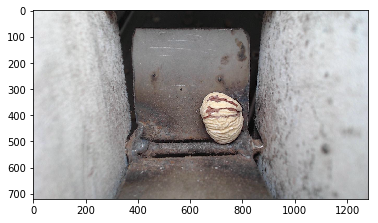

In [5]:
test_image = cv2.imread(os.path.join(POS_DIR, os.listdir(POS_DIR)[1]))
# print(test_image)
plt.imshow(test_image)
plt.show()

In [6]:
def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
#         RandomRotate90(),
#         Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),
        HueSaturationValue()
    ], p=p)

In [7]:
def strong_aug(p=.5):
    return Compose([
#         RandomRotate90(),
        Flip(),
#         Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.3),
            MedianBlur(blur_limit=3, p=0.2),
            Blur(blur_limit=3, p=0.2),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.2),
            IAAPiecewiseAffine(p=0.2),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [ ]:
aug = strong_aug(p=1)
for i in range(10):
    augment_and_show(aug, test_image)

In [8]:
def pool_images(image_list):
    img_pool = defaultdict(dict)
    for img_name in image_list:
        img_ts = img_name.split('_')[0]
        img_cam = int(img_name.split('_')[1].split('.')[0])
        img_pool[img_ts][img_cam] = img_name
    return img_pool

In [17]:
def preprocess_img_concat(img_dir, img_ts, image_names):
    images = {}
    for key, img_name in image_names.items():
        images[key] = cv2.imread(os.path.join(img_dir, img_name))
        mask = IMG_MASK[key]
        try:
            images[key] = images[key][mask[0]:mask[1], mask[2]:mask[3]]
        except TypeError:
            return None
    concat_img = np.concatenate((images[0],
                                 images[1],
                                 images[2]))
    concat_img = cv2.resize(concat_img, (T_WIDTH, T_HEIGHT))
    return (img_ts, concat_img)
    return images

In [18]:
def preprocess_img_concat_aug(img_dir, img_ts, image_names):
    images = {}
    for key, img_name in image_names.items():
        images[key] = cv2.imread(os.path.join(img_dir, img_name))
        mask = IMG_MASK[key]
        try:
            images[key] = images[key][mask[0]:mask[1], mask[2]:mask[3]]
        except TypeError:
            return None
    concat_img = np.concatenate((strong_aug(image=images[0])['image'],
                                 strong_aug(image=images[1])['image'],
                                 strong_aug(image=images[2])['image']))
    concat_img = cv2.resize(concat_img, (T_WIDTH, T_HEIGHT))
    return (img_ts, concat_img)
    return images

In [19]:
def preprocess_img_tuple(img_dir, img_ts, image_names):
    images = {}
    for key, img_name in image_names.items():
        images[key] = cv2.imread(os.path.join(img_dir, img_name))
        mask = IMG_MASK[key]
        try:
            images[key] = images[key][mask[0]:mask[1], mask[2]:mask[3]]
        except TypeError:
            return None
    try:
        tuple_img = (cv2.resize(images[0], (T_WIDTH, int(T_HEIGHT/3))),
                     cv2.resize(images[1], (T_WIDTH, int(T_HEIGHT/3))),
                     cv2.resize(images[2], (T_WIDTH, int(T_HEIGHT/3))))
    except:
        return None
    return (img_ts, tuple_img)
    return images

# Generate Dataset

In [38]:
pool = Pool(processes=30)
# pool.close()

In [39]:
# Generate the dataset from disk:
pos_images =  pool_images(os.listdir(POS_DIR))
neg_images = pool_images(os.listdir(NEG_DIR))
pos_ds = pool.starmap(preprocess_img_concat, zip(itertools.repeat(POS_DIR), pos_images.keys(), pos_images.values()))
neg_ds = pool.starmap(preprocess_img_concat, zip(itertools.repeat(NEG_DIR), neg_images.keys(), neg_images.values()))

ValueError: Pool not running

In [11]:
# Generate the augmented dataset from disk:
pos_images =  pool_images(os.listdir(POS_DIR))
neg_images = pool_images(os.listdir(NEG_DIR))
pos_ds = []
neg_ds = []
pre_pos = partial(preprocess_img_concat, img_dir=POS_DIR, img_aug=strong_aug(0.5, ))
neg_ds = pool.starmap(preprocess_img_concat, zip(itertools.repeat(POS_DIR), pos_images.keys(), pos_images.values()))
pos_ds = pool.starmap(preprocess_img_concat, zip(itertools.repeat(NEG_DIR), neg_images.keys(), neg_images.values()))

TypeError: strong_aug() got an unexpected keyword argument 'image'

In [24]:
# Remove buggy images 
for ds in [pos_ds, neg_ds]:
    count = 0
    e_count = 0 
    for idx, el in enumerate(ds):
        count += 1
        if el is None:
            ds.pop(idx)
            count += 1
    print(count, e_count)

3062 0
6094 0


In [29]:
pos_ds[0][1]

array([[[229, 236, 246],
        [231, 240, 250],
        [233, 243, 253],
        ...,
        [221, 232, 246],
        [216, 223, 239],
        [219, 229, 246]],

       [[238, 242, 252],
        [234, 242, 252],
        [218, 228, 238],
        ...,
        [219, 230, 244],
        [222, 229, 245],
        [220, 230, 247]],

       [[235, 244, 254],
        [233, 242, 252],
        [229, 238, 248],
        ...,
        [214, 225, 239],
        [212, 221, 237],
        [208, 215, 232]],

       ...,

       [[177, 175, 175],
        [174, 169, 170],
        [171, 165, 166],
        ...,
        [137, 138, 142],
        [112, 113, 117],
        [137, 137, 140]],

       [[180, 177, 176],
        [167, 162, 162],
        [166, 162, 162],
        ...,
        [129, 129, 134],
        [113, 110, 115],
        [130, 128, 131]],

       [[173, 168, 167],
        [159, 153, 152],
        [164, 161, 160],
        ...,
        [129, 129, 135],
        [122, 120, 126],
        [131, 130, 134]]

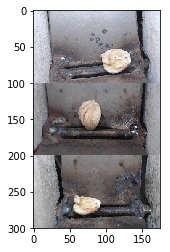

In [31]:
plt.imshow(pos_ds[1][1])
plt.show()

In [33]:
# Write out files to disk
for el in pos_ds:
    img = el[1]
    imageio.imwrite("{}.jpg".format(os.path.join(POS_TARGET_DIR, el[0])), img)
print("Positive done.")
for el in neg_ds:
    img = el[1]
    imageio.imwrite("{}.jpg".format(os.path.join(NEG_TARGET_DIR, el[0])), img)

    

Positive done.
